In [1]:
import sys
sys.path.append(r'../HelperFunctions')
import DataHelper as dh
import AugHelper as ah
import ModelConfigHelper as mch

In [2]:
path_info = dh.getFileDirectory()
path_info

Please enter the root directory of the file path -> C:\Users\user\Desktop\ML\PyTorch\Hackathon\Corn-Disease\Dataset\archive(5)\Corn Disease resized


{'path': 'C:\\Users\\user\\Desktop\\ML\\PyTorch\\Hackathon\\Corn-Disease\\Dataset\\archive(5)\\Corn Disease resized',
 'type': 'folder'}

In [3]:
dh.showFileCount(pathInfo=path_info)

Healthy corn :-
2000
Infected :-
2225


In [4]:
df = dh.getDataFrame(pathInfo=path_info)
df.info()
df.dtypes
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   imgPath       4225 non-null   object  
 1   label         4225 non-null   category
 2   augmentation  4225 non-null   object  
dtypes: category(1), object(2)
memory usage: 70.4+ KB


,imgPath,label,augmentation
0,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,Infected,normal
1,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,Healthy corn,normal
2,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,Healthy corn,normal
3,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,Healthy corn,normal
4,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,Healthy corn,normal
...,...,...,...
4220,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,Infected,normal
4221,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,Healthy corn,normal
4222,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,Infected,normal
4223,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,Healthy corn,normal


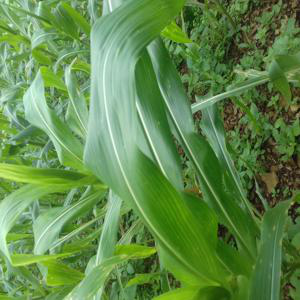

In [5]:
from PIL import Image
img = Image.open(df.iloc[5,0])
img

In [6]:
dictlabels=dh.getLabelDicts(df=df)
dictlabels

Index(['Healthy corn', 'Infected'], dtype='object')

In [7]:
df = dh.dfPreProcess(df=df)
df.info()
df.dtypes
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   imgPath       4225 non-null   object
 1   augmentation  4225 non-null   object
 2   ylabel        4225 non-null   int8  
dtypes: int8(1), object(2)
memory usage: 70.3+ KB


,imgPath,augmentation,ylabel
0,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,normal,1
1,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,normal,0
2,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,normal,0
3,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,normal,0
4,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,normal,0
...,...,...,...
4220,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,normal,1
4221,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,normal,0
4222,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,normal,1
4223,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Cor...,normal,0


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val = train_test_split(df,test_size=0.2)

In [9]:
augDict = ah.getAugmentation(augmentRequired=True,augmentPolicies=[ah.transforms.AutoAugmentPolicy.IMAGENET])
augDict

{'hFlip': RandomHorizontalFlip(p=1),
 'vFlip': RandomVerticalFlip(p=1),
 'rot': RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0),
 'aug0': AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)}

In [10]:
imgTransform = ah.getImageTransform(227)
imgTransform

Compose(
    Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [11]:
X_train = ah.augmentDataFrame(df=X_train,augDict=augDict)
X_train
X_train['augmentation'].unique()

array(['normal', 'rot', 'aug0', 'vFlip', 'hFlip'], dtype=object)

In [12]:
X_val
X_val['augmentation'].unique()

array(['normal'], dtype=object)

In [13]:
train_ds  = ah.KroniaDataset(data=X_train,transforms=imgTransform)
val_ds = ah.KroniaDataset(data=X_train,transforms=imgTransform)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [15]:
train_dl = DataLoader(dataset=train_ds,batch_size=64,shuffle=True)
val_dl = DataLoader(dataset=val_ds,batch_size=64,shuffle=True)

In [16]:
torch.manual_seed(42)
model = mch.getCustomizedPreTrainedModel('alexnet',len(dictlabels),feature_extract=True,preTrained=True)

In [17]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

In [19]:
train_loss,val_loss = mch.trainModel(model=model,train_dl=train_dl,val_dl=val_dl,criterion=criterion,optim=optimizer,train_samples=len(X_train),batch_size=64,soft_max=True,epochs=20)

============= New Epoch =========================
epoch:  0  batch:    2 [   128/16900]  loss: 0.61496425      accuracy:  60.938%
epoch:  0  batch:    4 [   256/16900]  loss: 0.46439993      accuracy:  70.312%
epoch:  0  batch:    6 [   384/16900]  loss: 0.33026460      accuracy:  75.000%
epoch:  0  batch:    8 [   512/16900]  loss: 0.29381368      accuracy:  78.320%
epoch:  0  batch:   10 [   640/16900]  loss: 0.37035897      accuracy:  79.219%
epoch:  0  batch:   12 [   768/16900]  loss: 0.40566438      accuracy:  79.818%
epoch:  0  batch:   14 [   896/16900]  loss: 0.27473962      accuracy:  80.804%
epoch:  0  batch:   16 [  1024/16900]  loss: 0.36365473      accuracy:  81.934%
epoch:  0  batch:   18 [  1152/16900]  loss: 0.21477777      accuracy:  83.073%
epoch:  0  batch:   20 [  1280/16900]  loss: 0.27424732      accuracy:  83.906%
epoch:  0  batch:   22 [  1408/16900]  loss: 0.21634555      accuracy:  84.517%
epoch:  0  batch:   24 [  1536/16900]  loss: 0.23058902      accuracy:

epoch:  0  batch:  206 [ 13184/16900]  loss: 0.13321538      accuracy:  91.391%
epoch:  0  batch:  208 [ 13312/16900]  loss: 0.21436125      accuracy:  91.376%
epoch:  0  batch:  210 [ 13440/16900]  loss: 0.15112858      accuracy:  91.391%
epoch:  0  batch:  212 [ 13568/16900]  loss: 0.24191046      accuracy:  91.369%
epoch:  0  batch:  214 [ 13696/16900]  loss: 0.20062637      accuracy:  91.384%
epoch:  0  batch:  216 [ 13824/16900]  loss: 0.25012651      accuracy:  91.363%
epoch:  0  batch:  218 [ 13952/16900]  loss: 0.16908321      accuracy:  91.378%
epoch:  0  batch:  220 [ 14080/16900]  loss: 0.24232070      accuracy:  91.378%
epoch:  0  batch:  222 [ 14208/16900]  loss: 0.22395512      accuracy:  91.385%
epoch:  0  batch:  224 [ 14336/16900]  loss: 0.22126079      accuracy:  91.385%
epoch:  0  batch:  226 [ 14464/16900]  loss: 0.13835411      accuracy:  91.427%
epoch:  0  batch:  228 [ 14592/16900]  loss: 0.07796126      accuracy:  91.482%
epoch:  0  batch:  230 [ 14720/16900]  l

epoch:  1  batch:  146 [  9344/16900]  loss: 0.12115016      accuracy:  93.333%
epoch:  1  batch:  148 [  9472/16900]  loss: 0.08499262      accuracy:  93.338%
epoch:  1  batch:  150 [  9600/16900]  loss: 0.12104920      accuracy:  93.385%
epoch:  1  batch:  152 [  9728/16900]  loss: 0.26866925      accuracy:  93.411%
epoch:  1  batch:  154 [  9856/16900]  loss: 0.08798891      accuracy:  93.446%
epoch:  1  batch:  156 [  9984/16900]  loss: 0.18450014      accuracy:  93.429%
epoch:  1  batch:  158 [ 10112/16900]  loss: 0.16484413      accuracy:  93.443%
epoch:  1  batch:  160 [ 10240/16900]  loss: 0.20050800      accuracy:  93.438%
epoch:  1  batch:  162 [ 10368/16900]  loss: 0.10280444      accuracy:  93.422%
epoch:  1  batch:  164 [ 10496/16900]  loss: 0.07323307      accuracy:  93.436%
epoch:  1  batch:  166 [ 10624/16900]  loss: 0.23391935      accuracy:  93.430%
epoch:  1  batch:  168 [ 10752/16900]  loss: 0.12723568      accuracy:  93.452%
epoch:  1  batch:  170 [ 10880/16900]  l

epoch:  2  batch:   86 [  5504/16900]  loss: 0.11742674      accuracy:  94.059%
epoch:  2  batch:   88 [  5632/16900]  loss: 0.07342162      accuracy:  94.087%
epoch:  2  batch:   90 [  5760/16900]  loss: 0.09448601      accuracy:  94.097%
epoch:  2  batch:   92 [  5888/16900]  loss: 0.21239699      accuracy:  94.124%
epoch:  2  batch:   94 [  6016/16900]  loss: 0.21149418      accuracy:  94.099%
epoch:  2  batch:   96 [  6144/16900]  loss: 0.17498827      accuracy:  94.092%
epoch:  2  batch:   98 [  6272/16900]  loss: 0.13860783      accuracy:  94.101%
epoch:  2  batch:  100 [  6400/16900]  loss: 0.17946063      accuracy:  94.094%
epoch:  2  batch:  102 [  6528/16900]  loss: 0.11741310      accuracy:  94.148%
epoch:  2  batch:  104 [  6656/16900]  loss: 0.28781784      accuracy:  94.126%
epoch:  2  batch:  106 [  6784/16900]  loss: 0.14855577      accuracy:  94.119%
epoch:  2  batch:  108 [  6912/16900]  loss: 0.12451518      accuracy:  94.126%
epoch:  2  batch:  110 [  7040/16900]  l

epoch:  3  batch:   26 [  1664/16900]  loss: 0.13225183      accuracy:  94.471%
epoch:  3  batch:   28 [  1792/16900]  loss: 0.14709394      accuracy:  94.643%
epoch:  3  batch:   30 [  1920/16900]  loss: 0.16612570      accuracy:  94.635%
epoch:  3  batch:   32 [  2048/16900]  loss: 0.11273057      accuracy:  94.629%
epoch:  3  batch:   34 [  2176/16900]  loss: 0.09680212      accuracy:  94.853%
epoch:  3  batch:   36 [  2304/16900]  loss: 0.12511665      accuracy:  94.792%
epoch:  3  batch:   38 [  2432/16900]  loss: 0.11127030      accuracy:  94.860%
epoch:  3  batch:   40 [  2560/16900]  loss: 0.12026536      accuracy:  94.766%
epoch:  3  batch:   42 [  2688/16900]  loss: 0.24105360      accuracy:  94.680%
epoch:  3  batch:   44 [  2816/16900]  loss: 0.04856369      accuracy:  94.709%
epoch:  3  batch:   46 [  2944/16900]  loss: 0.12030560      accuracy:  94.667%
epoch:  3  batch:   48 [  3072/16900]  loss: 0.17281133      accuracy:  94.727%
epoch:  3  batch:   50 [  3200/16900]  l

epoch:  3  batch:  232 [ 14848/16900]  loss: 0.07944047      accuracy:  94.430%
epoch:  3  batch:  234 [ 14976/16900]  loss: 0.14856499      accuracy:  94.438%
epoch:  3  batch:  236 [ 15104/16900]  loss: 0.06893930      accuracy:  94.465%
epoch:  3  batch:  238 [ 15232/16900]  loss: 0.13593547      accuracy:  94.472%
epoch:  3  batch:  240 [ 15360/16900]  loss: 0.13228948      accuracy:  94.479%
epoch:  3  batch:  242 [ 15488/16900]  loss: 0.16675088      accuracy:  94.473%
epoch:  3  batch:  244 [ 15616/16900]  loss: 0.10964876      accuracy:  94.480%
epoch:  3  batch:  246 [ 15744/16900]  loss: 0.11731218      accuracy:  94.493%
epoch:  3  batch:  248 [ 15872/16900]  loss: 0.05502108      accuracy:  94.512%
epoch:  3  batch:  250 [ 16000/16900]  loss: 0.13833188      accuracy:  94.525%
epoch:  3  batch:  252 [ 16128/16900]  loss: 0.15421027      accuracy:  94.537%
epoch:  3  batch:  254 [ 16256/16900]  loss: 0.10447720      accuracy:  94.544%
epoch:  3  batch:  256 [ 16384/16900]  l

epoch:  4  batch:  172 [ 11008/16900]  loss: 0.22371486      accuracy:  95.013%
epoch:  4  batch:  174 [ 11136/16900]  loss: 0.18350863      accuracy:  94.980%
epoch:  4  batch:  176 [ 11264/16900]  loss: 0.06869648      accuracy:  94.993%
epoch:  4  batch:  178 [ 11392/16900]  loss: 0.08966166      accuracy:  94.996%
epoch:  4  batch:  180 [ 11520/16900]  loss: 0.12431026      accuracy:  95.009%
epoch:  4  batch:  182 [ 11648/16900]  loss: 0.07746094      accuracy:  94.969%
epoch:  4  batch:  184 [ 11776/16900]  loss: 0.07838550      accuracy:  94.973%
epoch:  4  batch:  186 [ 11904/16900]  loss: 0.09589718      accuracy:  94.985%
epoch:  4  batch:  188 [ 12032/16900]  loss: 0.11018839      accuracy:  94.963%
epoch:  4  batch:  190 [ 12160/16900]  loss: 0.19624400      accuracy:  94.959%
epoch:  4  batch:  192 [ 12288/16900]  loss: 0.13566114      accuracy:  94.971%
epoch:  4  batch:  194 [ 12416/16900]  loss: 0.13986829      accuracy:  94.998%
epoch:  4  batch:  196 [ 12544/16900]  l

epoch:  5  batch:  112 [  7168/16900]  loss: 0.04677501      accuracy:  94.922%
epoch:  5  batch:  114 [  7296/16900]  loss: 0.09818900      accuracy:  94.929%
epoch:  5  batch:  116 [  7424/16900]  loss: 0.14178436      accuracy:  94.922%
epoch:  5  batch:  118 [  7552/16900]  loss: 0.11821332      accuracy:  94.928%
epoch:  5  batch:  120 [  7680/16900]  loss: 0.10922973      accuracy:  94.948%
epoch:  5  batch:  122 [  7808/16900]  loss: 0.08575137      accuracy:  94.992%
epoch:  5  batch:  124 [  7936/16900]  loss: 0.10021342      accuracy:  95.023%
epoch:  5  batch:  126 [  8064/16900]  loss: 0.17339148      accuracy:  94.990%
epoch:  5  batch:  128 [  8192/16900]  loss: 0.08206744      accuracy:  95.020%
epoch:  5  batch:  130 [  8320/16900]  loss: 0.06209033      accuracy:  95.072%
epoch:  5  batch:  132 [  8448/16900]  loss: 0.16069946      accuracy:  95.076%
epoch:  5  batch:  134 [  8576/16900]  loss: 0.17558050      accuracy:  95.056%
epoch:  5  batch:  136 [  8704/16900]  l

epoch:  6  batch:   52 [  3328/16900]  loss: 0.05124905      accuracy:  94.952%
epoch:  6  batch:   54 [  3456/16900]  loss: 0.09989465      accuracy:  95.052%
epoch:  6  batch:   56 [  3584/16900]  loss: 0.11240962      accuracy:  94.894%
epoch:  6  batch:   58 [  3712/16900]  loss: 0.02495297      accuracy:  94.935%
epoch:  6  batch:   60 [  3840/16900]  loss: 0.12317715      accuracy:  94.870%
epoch:  6  batch:   62 [  3968/16900]  loss: 0.10766988      accuracy:  94.859%
epoch:  6  batch:   64 [  4096/16900]  loss: 0.07806578      accuracy:  94.824%
epoch:  6  batch:   66 [  4224/16900]  loss: 0.07719617      accuracy:  94.863%
epoch:  6  batch:   68 [  4352/16900]  loss: 0.11471546      accuracy:  94.899%
epoch:  6  batch:   70 [  4480/16900]  loss: 0.18819197      accuracy:  94.888%
epoch:  6  batch:   72 [  4608/16900]  loss: 0.11545376      accuracy:  94.878%
epoch:  6  batch:   74 [  4736/16900]  loss: 0.16141270      accuracy:  94.890%
epoch:  6  batch:   76 [  4864/16900]  l

epoch:  6  batch:  258 [ 16512/16900]  loss: 0.07522152      accuracy:  95.034%
epoch:  6  batch:  260 [ 16640/16900]  loss: 0.14362305      accuracy:  95.018%
epoch:  6  batch:  262 [ 16768/16900]  loss: 0.09919109      accuracy:  95.026%
epoch:  6  batch:  264 [ 16896/16900]  loss: 0.09676420      accuracy:  95.034%
============= New Epoch =========================
epoch:  7  batch:    2 [   128/16900]  loss: 0.11900900      accuracy:  95.312%
epoch:  7  batch:    4 [   256/16900]  loss: 0.14001253      accuracy:  94.922%
epoch:  7  batch:    6 [   384/16900]  loss: 0.23805261      accuracy:  95.052%
epoch:  7  batch:    8 [   512/16900]  loss: 0.10084920      accuracy:  94.727%
epoch:  7  batch:   10 [   640/16900]  loss: 0.10516397      accuracy:  95.000%
epoch:  7  batch:   12 [   768/16900]  loss: 0.04933945      accuracy:  95.312%
epoch:  7  batch:   14 [   896/16900]  loss: 0.09094303      accuracy:  94.754%
epoch:  7  batch:   16 [  1024/16900]  loss: 0.03899977      accuracy:

epoch:  7  batch:  198 [ 12672/16900]  loss: 0.08865987      accuracy:  94.997%
epoch:  7  batch:  200 [ 12800/16900]  loss: 0.16854447      accuracy:  94.984%
epoch:  7  batch:  202 [ 12928/16900]  loss: 0.08540896      accuracy:  94.988%
epoch:  7  batch:  204 [ 13056/16900]  loss: 0.20725243      accuracy:  94.991%
epoch:  7  batch:  206 [ 13184/16900]  loss: 0.13010795      accuracy:  94.986%
epoch:  7  batch:  208 [ 13312/16900]  loss: 0.13746674      accuracy:  95.012%
epoch:  7  batch:  210 [ 13440/16900]  loss: 0.10450910      accuracy:  95.022%
epoch:  7  batch:  212 [ 13568/16900]  loss: 0.14263198      accuracy:  95.010%
epoch:  7  batch:  214 [ 13696/16900]  loss: 0.09364313      accuracy:  95.035%
epoch:  7  batch:  216 [ 13824/16900]  loss: 0.12694037      accuracy:  95.016%
epoch:  7  batch:  218 [ 13952/16900]  loss: 0.07335036      accuracy:  95.019%
epoch:  7  batch:  220 [ 14080/16900]  loss: 0.07423687      accuracy:  95.021%
epoch:  7  batch:  222 [ 14208/16900]  l

epoch:  8  batch:  138 [  8832/16900]  loss: 0.17481814      accuracy:  95.335%
epoch:  8  batch:  140 [  8960/16900]  loss: 0.10240726      accuracy:  95.368%
epoch:  8  batch:  142 [  9088/16900]  loss: 0.09494214      accuracy:  95.401%
epoch:  8  batch:  144 [  9216/16900]  loss: 0.10386685      accuracy:  95.421%
epoch:  8  batch:  146 [  9344/16900]  loss: 0.16814874      accuracy:  95.430%
epoch:  8  batch:  148 [  9472/16900]  loss: 0.19184050      accuracy:  95.376%
epoch:  8  batch:  150 [  9600/16900]  loss: 0.14568122      accuracy:  95.385%
epoch:  8  batch:  152 [  9728/16900]  loss: 0.08351034      accuracy:  95.384%
epoch:  8  batch:  154 [  9856/16900]  loss: 0.15977196      accuracy:  95.394%
epoch:  8  batch:  156 [  9984/16900]  loss: 0.18003796      accuracy:  95.403%
epoch:  8  batch:  158 [ 10112/16900]  loss: 0.11996283      accuracy:  95.392%
epoch:  8  batch:  160 [ 10240/16900]  loss: 0.10559275      accuracy:  95.400%
epoch:  8  batch:  162 [ 10368/16900]  l

epoch:  9  batch:   78 [  4992/16900]  loss: 0.07726283      accuracy:  95.292%
epoch:  9  batch:   80 [  5120/16900]  loss: 0.06263573      accuracy:  95.391%
epoch:  9  batch:   82 [  5248/16900]  loss: 0.18634242      accuracy:  95.389%
epoch:  9  batch:   84 [  5376/16900]  loss: 0.07475100      accuracy:  95.387%
epoch:  9  batch:   86 [  5504/16900]  loss: 0.05130724      accuracy:  95.458%
epoch:  9  batch:   88 [  5632/16900]  loss: 0.14076288      accuracy:  95.437%
epoch:  9  batch:   90 [  5760/16900]  loss: 0.11052749      accuracy:  95.399%
epoch:  9  batch:   92 [  5888/16900]  loss: 0.12046350      accuracy:  95.329%
epoch:  9  batch:   94 [  6016/16900]  loss: 0.12009972      accuracy:  95.329%
epoch:  9  batch:   96 [  6144/16900]  loss: 0.15903902      accuracy:  95.329%
epoch:  9  batch:   98 [  6272/16900]  loss: 0.10326321      accuracy:  95.344%
epoch:  9  batch:  100 [  6400/16900]  loss: 0.05639819      accuracy:  95.406%
epoch:  9  batch:  102 [  6528/16900]  l

epoch: 10  batch:   18 [  1152/16900]  loss: 0.08969396      accuracy:  95.052%
epoch: 10  batch:   20 [  1280/16900]  loss: 0.16319384      accuracy:  94.609%
epoch: 10  batch:   22 [  1408/16900]  loss: 0.05306004      accuracy:  94.815%
epoch: 10  batch:   24 [  1536/16900]  loss: 0.14357725      accuracy:  94.922%
epoch: 10  batch:   26 [  1664/16900]  loss: 0.10250481      accuracy:  94.892%
epoch: 10  batch:   28 [  1792/16900]  loss: 0.11301151      accuracy:  94.866%
epoch: 10  batch:   30 [  1920/16900]  loss: 0.10838971      accuracy:  95.052%
epoch: 10  batch:   32 [  2048/16900]  loss: 0.18768270      accuracy:  95.068%
epoch: 10  batch:   34 [  2176/16900]  loss: 0.07924418      accuracy:  95.129%
epoch: 10  batch:   36 [  2304/16900]  loss: 0.11676970      accuracy:  95.182%
epoch: 10  batch:   38 [  2432/16900]  loss: 0.17710884      accuracy:  95.107%
epoch: 10  batch:   40 [  2560/16900]  loss: 0.09477104      accuracy:  95.117%
epoch: 10  batch:   42 [  2688/16900]  l

epoch: 10  batch:  224 [ 14336/16900]  loss: 0.08767545      accuracy:  95.117%
epoch: 10  batch:  226 [ 14464/16900]  loss: 0.16283625      accuracy:  95.119%
epoch: 10  batch:  228 [ 14592/16900]  loss: 0.10809555      accuracy:  95.114%
epoch: 10  batch:  230 [ 14720/16900]  loss: 0.10400315      accuracy:  95.129%
epoch: 10  batch:  232 [ 14848/16900]  loss: 0.12093623      accuracy:  95.151%
epoch: 10  batch:  234 [ 14976/16900]  loss: 0.13372838      accuracy:  95.139%
epoch: 10  batch:  236 [ 15104/16900]  loss: 0.03053386      accuracy:  95.167%
epoch: 10  batch:  238 [ 15232/16900]  loss: 0.10809729      accuracy:  95.175%
epoch: 10  batch:  240 [ 15360/16900]  loss: 0.11357710      accuracy:  95.156%
epoch: 10  batch:  242 [ 15488/16900]  loss: 0.12914376      accuracy:  95.145%
epoch: 10  batch:  244 [ 15616/16900]  loss: 0.10166198      accuracy:  95.140%
epoch: 10  batch:  246 [ 15744/16900]  loss: 0.23221663      accuracy:  95.109%
epoch: 10  batch:  248 [ 15872/16900]  l

epoch: 11  batch:  164 [ 10496/16900]  loss: 0.07283097      accuracy:  94.970%
epoch: 11  batch:  166 [ 10624/16900]  loss: 0.03779432      accuracy:  95.011%
epoch: 11  batch:  168 [ 10752/16900]  loss: 0.13689680      accuracy:  94.996%
epoch: 11  batch:  170 [ 10880/16900]  loss: 0.05376670      accuracy:  95.028%
epoch: 11  batch:  172 [ 11008/16900]  loss: 0.09438617      accuracy:  95.031%
epoch: 11  batch:  174 [ 11136/16900]  loss: 0.27530178      accuracy:  94.989%
epoch: 11  batch:  176 [ 11264/16900]  loss: 0.10030121      accuracy:  95.002%
epoch: 11  batch:  178 [ 11392/16900]  loss: 0.13447972      accuracy:  94.953%
epoch: 11  batch:  180 [ 11520/16900]  loss: 0.18120791      accuracy:  94.948%
epoch: 11  batch:  182 [ 11648/16900]  loss: 0.19676572      accuracy:  94.952%
epoch: 11  batch:  184 [ 11776/16900]  loss: 0.07393701      accuracy:  94.973%
epoch: 11  batch:  186 [ 11904/16900]  loss: 0.10440845      accuracy:  95.002%
epoch: 11  batch:  188 [ 12032/16900]  l

epoch: 12  batch:  104 [  6656/16900]  loss: 0.09562638      accuracy:  95.027%
epoch: 12  batch:  106 [  6784/16900]  loss: 0.07372207      accuracy:  95.062%
epoch: 12  batch:  108 [  6912/16900]  loss: 0.09486438      accuracy:  95.081%
epoch: 12  batch:  110 [  7040/16900]  loss: 0.07737642      accuracy:  95.114%
epoch: 12  batch:  112 [  7168/16900]  loss: 0.06740879      accuracy:  95.145%
epoch: 12  batch:  114 [  7296/16900]  loss: 0.14234124      accuracy:  95.134%
epoch: 12  batch:  116 [  7424/16900]  loss: 0.10743168      accuracy:  95.164%
epoch: 12  batch:  118 [  7552/16900]  loss: 0.06747378      accuracy:  95.220%
epoch: 12  batch:  120 [  7680/16900]  loss: 0.13424283      accuracy:  95.182%
epoch: 12  batch:  122 [  7808/16900]  loss: 0.11711241      accuracy:  95.172%
epoch: 12  batch:  124 [  7936/16900]  loss: 0.15902010      accuracy:  95.111%
epoch: 12  batch:  126 [  8064/16900]  loss: 0.11732864      accuracy:  95.126%
epoch: 12  batch:  128 [  8192/16900]  l

epoch: 13  batch:   44 [  2816/16900]  loss: 0.09072070      accuracy:  94.460%
epoch: 13  batch:   46 [  2944/16900]  loss: 0.08183505      accuracy:  94.565%
epoch: 13  batch:   48 [  3072/16900]  loss: 0.13098550      accuracy:  94.564%
epoch: 13  batch:   50 [  3200/16900]  loss: 0.17163093      accuracy:  94.469%
epoch: 13  batch:   52 [  3328/16900]  loss: 0.21076936      accuracy:  94.321%
epoch: 13  batch:   54 [  3456/16900]  loss: 0.10064982      accuracy:  94.416%
epoch: 13  batch:   56 [  3584/16900]  loss: 0.04872670      accuracy:  94.531%
epoch: 13  batch:   58 [  3712/16900]  loss: 0.05642641      accuracy:  94.612%
epoch: 13  batch:   60 [  3840/16900]  loss: 0.06026092      accuracy:  94.714%
epoch: 13  batch:   62 [  3968/16900]  loss: 0.04381337      accuracy:  94.808%
epoch: 13  batch:   64 [  4096/16900]  loss: 0.07159948      accuracy:  94.849%
epoch: 13  batch:   66 [  4224/16900]  loss: 0.05862651      accuracy:  94.934%
epoch: 13  batch:   68 [  4352/16900]  l

epoch: 13  batch:  250 [ 16000/16900]  loss: 0.13208228      accuracy:  95.263%
epoch: 13  batch:  252 [ 16128/16900]  loss: 0.11988466      accuracy:  95.275%
epoch: 13  batch:  254 [ 16256/16900]  loss: 0.25614810      accuracy:  95.269%
epoch: 13  batch:  256 [ 16384/16900]  loss: 0.15173309      accuracy:  95.245%
epoch: 13  batch:  258 [ 16512/16900]  loss: 0.29201478      accuracy:  95.234%
epoch: 13  batch:  260 [ 16640/16900]  loss: 0.12449382      accuracy:  95.234%
epoch: 13  batch:  262 [ 16768/16900]  loss: 0.16086523      accuracy:  95.235%
epoch: 13  batch:  264 [ 16896/16900]  loss: 0.03268895      accuracy:  95.247%
============= New Epoch =========================
epoch: 14  batch:    2 [   128/16900]  loss: 0.15788513      accuracy:  93.750%
epoch: 14  batch:    4 [   256/16900]  loss: 0.06720748      accuracy:  94.922%
epoch: 14  batch:    6 [   384/16900]  loss: 0.05391558      accuracy:  95.573%
epoch: 14  batch:    8 [   512/16900]  loss: 0.11522183      accuracy:

epoch: 14  batch:  190 [ 12160/16900]  loss: 0.05179652      accuracy:  95.559%
epoch: 14  batch:  192 [ 12288/16900]  loss: 0.06770183      accuracy:  95.565%
epoch: 14  batch:  194 [ 12416/16900]  loss: 0.13552879      accuracy:  95.554%
epoch: 14  batch:  196 [ 12544/16900]  loss: 0.26913232      accuracy:  95.544%
epoch: 14  batch:  198 [ 12672/16900]  loss: 0.15638660      accuracy:  95.557%
epoch: 14  batch:  200 [ 12800/16900]  loss: 0.06379260      accuracy:  95.547%
epoch: 14  batch:  202 [ 12928/16900]  loss: 0.03625194      accuracy:  95.552%
epoch: 14  batch:  204 [ 13056/16900]  loss: 0.09969484      accuracy:  95.581%
epoch: 14  batch:  206 [ 13184/16900]  loss: 0.15427321      accuracy:  95.555%
epoch: 14  batch:  208 [ 13312/16900]  loss: 0.22115773      accuracy:  95.508%
epoch: 14  batch:  210 [ 13440/16900]  loss: 0.18195879      accuracy:  95.506%
epoch: 14  batch:  212 [ 13568/16900]  loss: 0.07282724      accuracy:  95.511%
epoch: 14  batch:  214 [ 13696/16900]  l

epoch: 15  batch:  130 [  8320/16900]  loss: 0.15634510      accuracy:  94.928%
epoch: 15  batch:  132 [  8448/16900]  loss: 0.15031965      accuracy:  94.946%
epoch: 15  batch:  134 [  8576/16900]  loss: 0.07806382      accuracy:  94.963%
epoch: 15  batch:  136 [  8704/16900]  loss: 0.14381132      accuracy:  94.956%
epoch: 15  batch:  138 [  8832/16900]  loss: 0.08157514      accuracy:  94.973%
epoch: 15  batch:  140 [  8960/16900]  loss: 0.10241773      accuracy:  95.000%
epoch: 15  batch:  142 [  9088/16900]  loss: 0.13202216      accuracy:  94.993%
epoch: 15  batch:  144 [  9216/16900]  loss: 0.02966058      accuracy:  95.052%
epoch: 15  batch:  146 [  9344/16900]  loss: 0.13289750      accuracy:  95.066%
epoch: 15  batch:  148 [  9472/16900]  loss: 0.15971398      accuracy:  95.080%
epoch: 15  batch:  150 [  9600/16900]  loss: 0.07478111      accuracy:  95.083%
epoch: 15  batch:  152 [  9728/16900]  loss: 0.11021475      accuracy:  95.107%
epoch: 15  batch:  154 [  9856/16900]  l

epoch: 16  batch:   70 [  4480/16900]  loss: 0.13041931      accuracy:  95.246%
epoch: 16  batch:   72 [  4608/16900]  loss: 0.10209461      accuracy:  95.247%
epoch: 16  batch:   74 [  4736/16900]  loss: 0.08308628      accuracy:  95.249%
epoch: 16  batch:   76 [  4864/16900]  loss: 0.08223483      accuracy:  95.251%
epoch: 16  batch:   78 [  4992/16900]  loss: 0.12980829      accuracy:  95.212%
epoch: 16  batch:   80 [  5120/16900]  loss: 0.07282698      accuracy:  95.273%
epoch: 16  batch:   82 [  5248/16900]  loss: 0.11929011      accuracy:  95.293%
epoch: 16  batch:   84 [  5376/16900]  loss: 0.17884964      accuracy:  95.312%
epoch: 16  batch:   86 [  5504/16900]  loss: 0.06966965      accuracy:  95.349%
epoch: 16  batch:   88 [  5632/16900]  loss: 0.11955602      accuracy:  95.366%
epoch: 16  batch:   90 [  5760/16900]  loss: 0.13095900      accuracy:  95.347%
epoch: 16  batch:   92 [  5888/16900]  loss: 0.08481690      accuracy:  95.363%
epoch: 16  batch:   94 [  6016/16900]  l

epoch: 17  batch:   10 [   640/16900]  loss: 0.14779508      accuracy:  95.469%
epoch: 17  batch:   12 [   768/16900]  loss: 0.11394365      accuracy:  95.443%
epoch: 17  batch:   14 [   896/16900]  loss: 0.12829550      accuracy:  95.536%
epoch: 17  batch:   16 [  1024/16900]  loss: 0.15930338      accuracy:  95.508%
epoch: 17  batch:   18 [  1152/16900]  loss: 0.13295265      accuracy:  95.573%
epoch: 17  batch:   20 [  1280/16900]  loss: 0.12237223      accuracy:  95.469%
epoch: 17  batch:   22 [  1408/16900]  loss: 0.19822928      accuracy:  95.312%
epoch: 17  batch:   24 [  1536/16900]  loss: 0.20302343      accuracy:  95.182%
epoch: 17  batch:   26 [  1664/16900]  loss: 0.04758967      accuracy:  95.312%
epoch: 17  batch:   28 [  1792/16900]  loss: 0.12389711      accuracy:  95.201%
epoch: 17  batch:   30 [  1920/16900]  loss: 0.08586404      accuracy:  95.417%
epoch: 17  batch:   32 [  2048/16900]  loss: 0.07337435      accuracy:  95.361%
epoch: 17  batch:   34 [  2176/16900]  l

epoch: 17  batch:  216 [ 13824/16900]  loss: 0.06998164      accuracy:  95.255%
epoch: 17  batch:  218 [ 13952/16900]  loss: 0.06963223      accuracy:  95.255%
epoch: 17  batch:  220 [ 14080/16900]  loss: 0.19257389      accuracy:  95.263%
epoch: 17  batch:  222 [ 14208/16900]  loss: 0.04018570      accuracy:  95.284%
epoch: 17  batch:  224 [ 14336/16900]  loss: 0.02849483      accuracy:  95.306%
epoch: 17  batch:  226 [ 14464/16900]  loss: 0.12556607      accuracy:  95.271%
epoch: 17  batch:  228 [ 14592/16900]  loss: 0.10000001      accuracy:  95.285%
epoch: 17  batch:  230 [ 14720/16900]  loss: 0.13998884      accuracy:  95.251%
epoch: 17  batch:  232 [ 14848/16900]  loss: 0.14179198      accuracy:  95.265%
epoch: 17  batch:  234 [ 14976/16900]  loss: 0.07130891      accuracy:  95.279%
epoch: 17  batch:  236 [ 15104/16900]  loss: 0.09832092      accuracy:  95.293%
epoch: 17  batch:  238 [ 15232/16900]  loss: 0.22422899      accuracy:  95.247%
epoch: 17  batch:  240 [ 15360/16900]  l

epoch: 18  batch:  156 [  9984/16900]  loss: 0.09368602      accuracy:  95.513%
epoch: 18  batch:  158 [ 10112/16900]  loss: 0.08479780      accuracy:  95.500%
epoch: 18  batch:  160 [ 10240/16900]  loss: 0.18094155      accuracy:  95.479%
epoch: 18  batch:  162 [ 10368/16900]  loss: 0.16784269      accuracy:  95.467%
epoch: 18  batch:  164 [ 10496/16900]  loss: 0.06355184      accuracy:  95.446%
epoch: 18  batch:  166 [ 10624/16900]  loss: 0.13349493      accuracy:  95.454%
epoch: 18  batch:  168 [ 10752/16900]  loss: 0.08470414      accuracy:  95.443%
epoch: 18  batch:  170 [ 10880/16900]  loss: 0.03074128      accuracy:  95.450%
epoch: 18  batch:  172 [ 11008/16900]  loss: 0.15177324      accuracy:  95.431%
epoch: 18  batch:  174 [ 11136/16900]  loss: 0.18322133      accuracy:  95.402%
epoch: 18  batch:  176 [ 11264/16900]  loss: 0.03499228      accuracy:  95.401%
epoch: 18  batch:  178 [ 11392/16900]  loss: 0.05918681      accuracy:  95.418%
epoch: 18  batch:  180 [ 11520/16900]  l

epoch: 19  batch:   96 [  6144/16900]  loss: 0.12451735      accuracy:  95.231%
epoch: 19  batch:   98 [  6272/16900]  loss: 0.12569286      accuracy:  95.169%
epoch: 19  batch:  100 [  6400/16900]  loss: 0.03786150      accuracy:  95.203%
epoch: 19  batch:  102 [  6528/16900]  loss: 0.09715644      accuracy:  95.221%
epoch: 19  batch:  104 [  6656/16900]  loss: 0.06525870      accuracy:  95.177%
epoch: 19  batch:  106 [  6784/16900]  loss: 0.09765022      accuracy:  95.136%
epoch: 19  batch:  108 [  6912/16900]  loss: 0.07775217      accuracy:  95.182%
epoch: 19  batch:  110 [  7040/16900]  loss: 0.09446181      accuracy:  95.170%
epoch: 19  batch:  112 [  7168/16900]  loss: 0.20638174      accuracy:  95.117%
epoch: 19  batch:  114 [  7296/16900]  loss: 0.10273309      accuracy:  95.134%
epoch: 19  batch:  116 [  7424/16900]  loss: 0.08303068      accuracy:  95.164%
epoch: 19  batch:  118 [  7552/16900]  loss: 0.09149516      accuracy:  95.193%
epoch: 19  batch:  120 [  7680/16900]  l

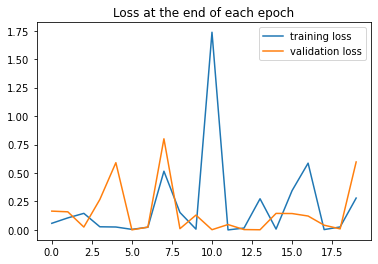

In [20]:
mch.visualiziseTrainResults(train_losses=train_loss,test_losses=val_loss)

In [21]:
# mch.saveModel(model=model,filename="CornDisease")